# Sieć GAN

Ten notatnik implementuje sieć GAN. Wykorzystuje zmodyfikowany kod [Rowela Atienza](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/Experiments/Tensorflow/GAN/dcgan_mnist.py) [licencja [MIT](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/LICENSE)] do tworzenia szkiców wzorowanych na rysunkach utworzonych przez ludzi w serwisie  [*Quick, Draw!*](https://quickdraw.withgoogle.com). Dane są dostępne [tutaj](https://github.com/googlecreativelab/quickdraw-dataset), zgodnie z licencją [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/)).

#### Załadowanie zależności.


In [6]:
# Pobieranie i generowanie danych:
import numpy as np
import os

# Głębokie uczenie:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape # Nowość!
from keras.layers import Conv2DTranspose, UpSampling2D # Nowość!
from keras.optimizers import RMSprop # Nowość!

# Tworzenie wykresów:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### Załadowanie danych.

In [7]:
# Import dysku google.colab.
# drive.mount('/content/gdrive')
# os.chdir('/content/gdrive/My Drive/Colab Notebooks/quickdraw_data')

In [8]:
input_images = "./quickdraw_data/apple.npy"

In [9]:
data = np.load(input_images) # Bitmapa 28x28 pikseli, w odcieniach szarości, w formacie .npy format. Obraz jest wyśrodkowany.

In [10]:
data.shape

(144722, 784)

In [11]:
data[4242]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  36,  79,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 134, 238,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 119, 254,   4,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 101, 255,  21,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  82, 255,  39,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [12]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1)) # Czwartym wymiarem jest kolor.
img_w,img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

In [13]:
data[4242]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.14117647],
        [0.30980392],
        [0.        ],
        [0.        ],
        

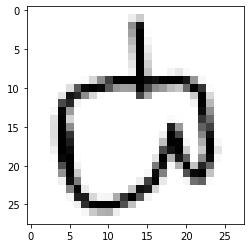

In [14]:
plt.imshow(data[4242,:,:,0], cmap='Greys')

#### Utworzenie sieci dyskryminatora.

In [15]:
def build_discriminator(depth=64, p=0.4):

    # Definicja danych wejściowych:
    image = Input((img_w,img_h,1))
    
    # Warstwy konwolucyjne:
    conv1 = Conv2D(depth*1, 5, strides=2, 
                   padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, 
                   padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, 
                   padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, 
                   padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # Warstwa wyjściowa:
    prediction = Dense(1, activation='sigmoid')(conv4)
    
    # Definicja modelu:
    model = Model(inputs=image, outputs=prediction)
    
    return model

In [16]:
discriminator = build_discriminator()

In [17]:
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)         0     

In [18]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0008, 
                                        decay=6e-8, 
                                        clipvalue=1.0), 
                      metrics=['accuracy'])

_Ciekawe, że w przypadku użycia zwykłego procesora CPU do przetrenowania modelu (tj. nie GPU), optymalizator RMSprop prawie zawsze zawodzi. Zamiast niego można skompilować model z optymalizatorem AdaGrad lub Adamem za pomocą poniższego (wykomentowanego) kodu._

In [19]:
# from keras.optimizers import Adam 
# discriminator.compile(loss='binary_crossentropy', 
#                       optimizer=Adam(lr=0.0008, 
#                                      clipvalue=1.0), 
#                       metrics=['accuracy'])

#### Utworzenie sieci generatora.

In [20]:
z_dimensions = 32

In [21]:
def build_generator(latent_dim=z_dimensions, 
                    depth=64, p=0.4):
    
    # Definicja danych wejściowych:
    noise = Input((latent_dim,))
    
    # Pierwsza warstwa zagęszczona:
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # Domyślny impet dla średniej ruchomej jest równy 0.99.
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # Warstwy dekonwolucyjne:
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Warstwa wyjściowa:
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # Definicja modelu: 
    model = Model(inputs=noise, outputs=image)
    
    return model

In [22]:
generator = build_generator()

In [23]:
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              103488    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation (Activation)      (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0   

#### Utworzenie sieci antagonistycznej.

In [24]:
z = Input(shape=(z_dimensions,))
img = generator(z)

In [25]:
discriminator.trainable = False

In [26]:
pred = discriminator(img)

In [27]:
adversarial_model = Model(z, pred)

In [28]:
adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=RMSprop(lr=0.0004, 
                                            decay=3e-8, 
                                            clipvalue=1.0), 
                          metrics=['accuracy'])

#### Trening!


In [29]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        # Przykładowe prawdziwe obrazy: 
        real_imgs = np.reshape(
            data[np.random.choice(data.shape[0],
                                  batch,
                                  replace=False)],
            (batch,28,28,1))
        
        # Tworzenie fałszywych obrazów: 
        fake_imgs = generator.predict(
            np.random.uniform(-1.0, 1.0, 
                              size=[batch, z_dim]))
        
        # Zebranie obrazów w celu przekazania dyskryminatorowi:
        x = np.concatenate((real_imgs,fake_imgs))
        
        # Przypisanie etykiet y dla dyskryminatora:
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        # Trening dyskryminatora:
        d_metrics.append(
            discriminator.train_on_batch(x,y)
        )
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        # Losowe wartości wejściowe i "prawdziwa" wartość y:
        noise = np.random.uniform(-1.0, 1.0, 
                                  size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # Trening sieci antagonistycznej:
        a_metrics.append(
            adversarial_model.train_on_batch(noise,y)
        ) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        # Okresowe wyświetlanie informacji o postępie i fałszywych obrazach:
        if (i+1)%100 == 0:

            print('Epoka {}'.format(i))
            log_mesg = "%d: [Dyskr.: strata %f, dokł. %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s [Sieć: strata %f, dokł. %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], 
                           cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

Epoka 99
99: [Dyskr.: strata 0.352568, dokł. 0.934738] [Sieć: strata 2.502856, dokł. 0.353851]


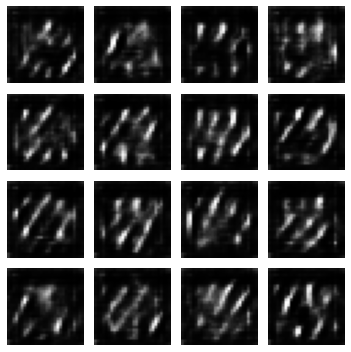

Epoka 199
199: [Dyskr.: strata 0.354859, dokł. 0.924388] [Sieć: strata 2.931572, dokł. 0.203086]


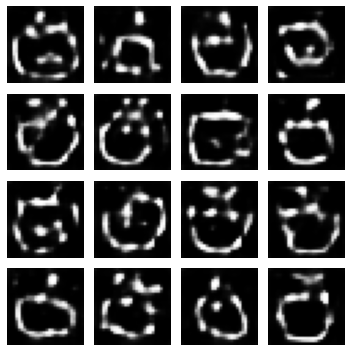

Epoka 299
299: [Dyskr.: strata 0.382929, dokł. 0.890677] [Sieć: strata 2.724895, dokł. 0.183685]


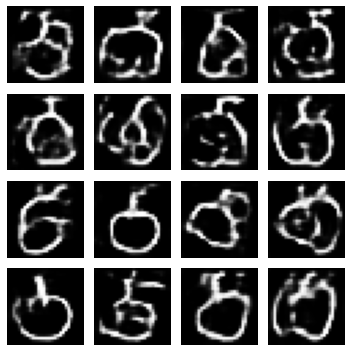

Epoka 399
399: [Dyskr.: strata 0.408829, dokł. 0.861744] [Sieć: strata 2.463245, dokł. 0.180197]


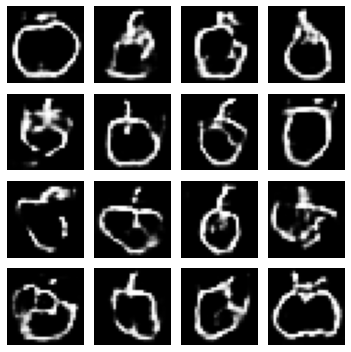

Epoka 499
499: [Dyskr.: strata 0.418948, dokł. 0.846568] [Sieć: strata 2.329674, dokł. 0.172877]


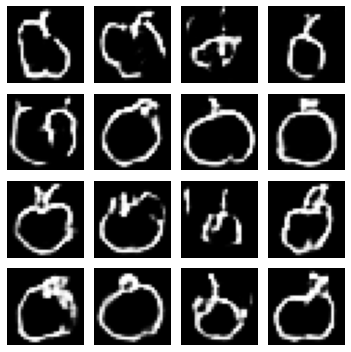

Epoka 599
599: [Dyskr.: strata 0.420989, dokł. 0.839042] [Sieć: strata 2.271210, dokł. 0.165275]


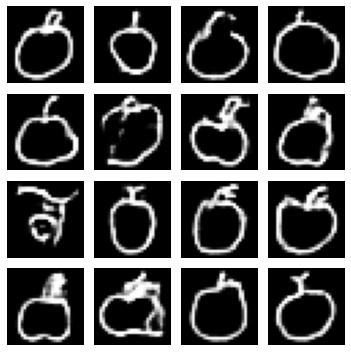

Epoka 699
699: [Dyskr.: strata 0.420222, dokł. 0.834479] [Sieć: strata 2.249781, dokł. 0.159569]


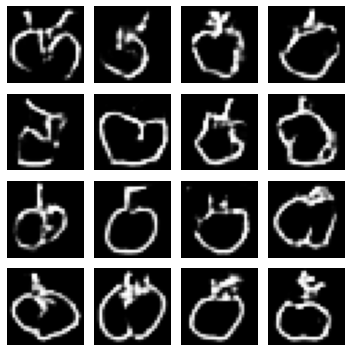

Epoka 799
799: [Dyskr.: strata 0.418564, dokł. 0.831723] [Sieć: strata 2.245872, dokł. 0.155497]


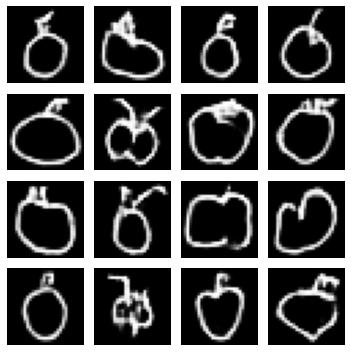

Epoka 899
899: [Dyskr.: strata 0.416159, dokł. 0.830411] [Sieć: strata 2.250738, dokł. 0.152027]


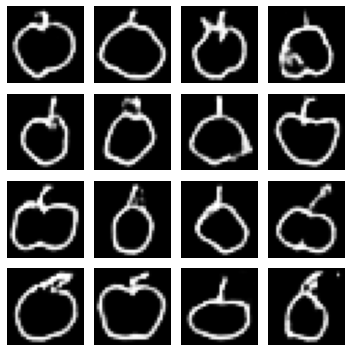

Epoka 999
999: [Dyskr.: strata 0.413163, dokł. 0.830236] [Sieć: strata 2.265989, dokł. 0.148961]


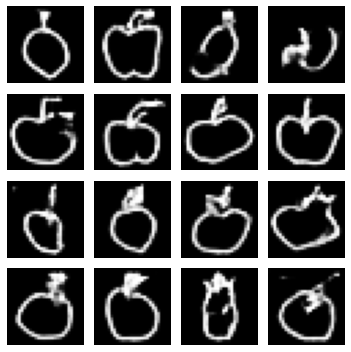

Epoka 1099
1099: [Dyskr.: strata 0.408793, dokł. 0.830851] [Sieć: strata 2.291076, dokł. 0.145516]


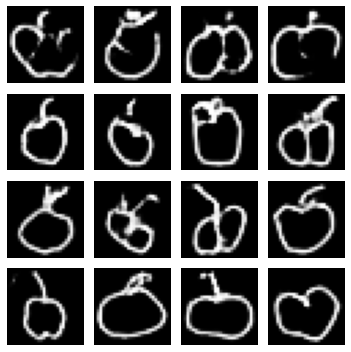

Epoka 1199
1199: [Dyskr.: strata 0.404887, dokł. 0.831790] [Sieć: strata 2.322889, dokł. 0.142241]


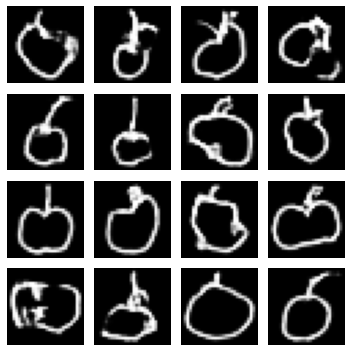

Epoka 1299
1299: [Dyskr.: strata 0.400619, dokł. 0.833015] [Sieć: strata 2.347833, dokł. 0.139013]


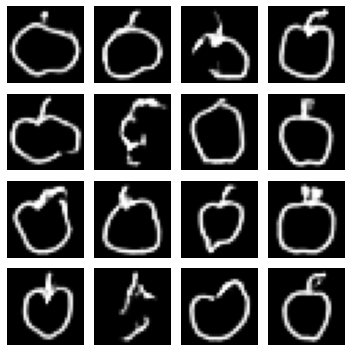

Epoka 1399
1399: [Dyskr.: strata 0.395858, dokł. 0.834421] [Sieć: strata 2.384017, dokł. 0.136102]


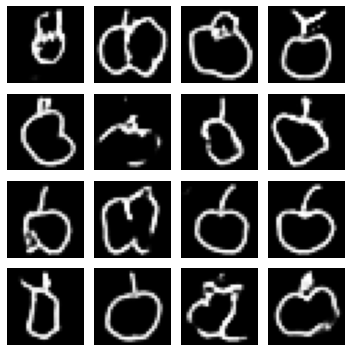

Epoka 1499
1499: [Dyskr.: strata 0.391617, dokł. 0.835716] [Sieć: strata 2.418124, dokł. 0.133652]


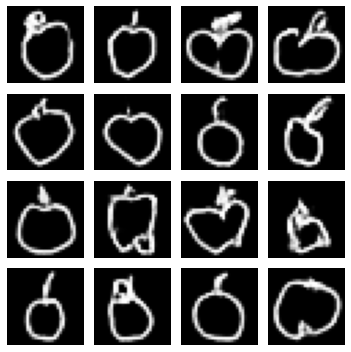

Epoka 1599
1599: [Dyskr.: strata 0.387742, dokł. 0.837034] [Sieć: strata 2.450846, dokł. 0.131273]


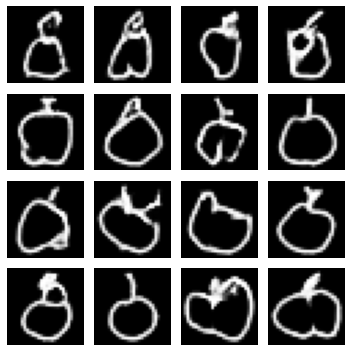

Epoka 1699
1699: [Dyskr.: strata 0.383653, dokł. 0.838607] [Sieć: strata 2.489138, dokł. 0.128725]


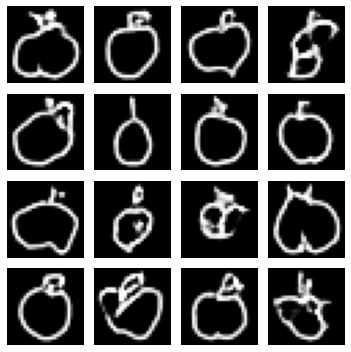

Epoka 1799
1799: [Dyskr.: strata 0.379712, dokł. 0.840076] [Sieć: strata 2.523579, dokł. 0.126646]


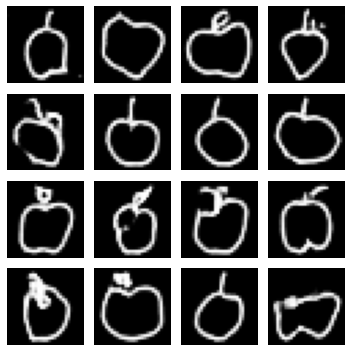

Epoka 1899
1899: [Dyskr.: strata 0.376200, dokł. 0.841415] [Sieć: strata 2.559261, dokł. 0.124572]


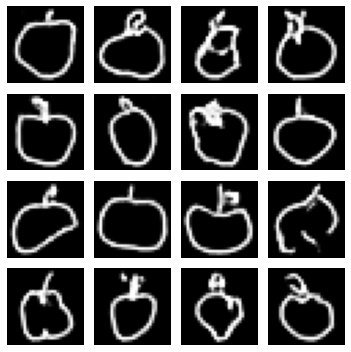

Epoka 1999
1999: [Dyskr.: strata 0.373095, dokł. 0.842515] [Sieć: strata 2.586890, dokł. 0.122643]


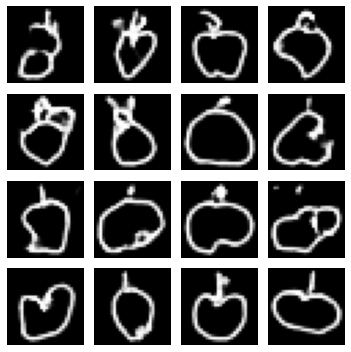

In [30]:
a_metrics_complete, d_metrics_complete = train()

Text(0, 0.5, 'Strata')

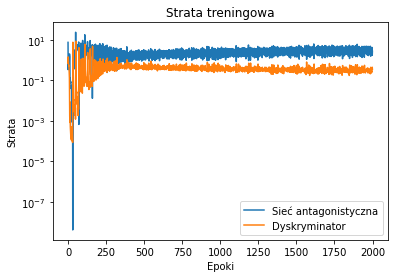

In [31]:
ax = pd.DataFrame(
    {
        'Sieć antagonistyczna': [metric[0] for metric in a_metrics_complete],
        'Dyskryminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Strata treningowa', logy=True)
ax.set_xlabel("Epoki")
ax.set_ylabel("Strata")

Text(0, 0.5, 'Dokładność')

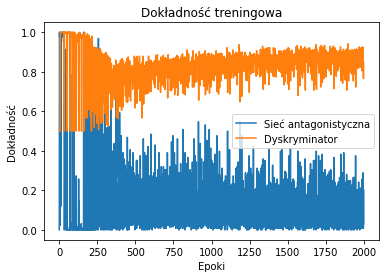

In [32]:
ax = pd.DataFrame(
    {
        'Sieć antagonistyczna': [metric[1] for metric in a_metrics_complete],
        'Dyskryminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Dokładność treningowa')
ax.set_xlabel("Epoki")
ax.set_ylabel("Dokładność")